In [9]:
from matplotlib import pyplot as plot
from matplotlib import animation

from itertools import permutations
import numpy

%matplotlib inline

# Winota, Joiner of Distributions

This notebook will examine one of the new _Magic: the Gathering_ mythic creatues, <a href="https://scryfall.com/card/iko/216/winota-joiner-of-forces" class = "hover">Winota, Joiner of Forces<img src="https://img.scryfall.com/cards/small/front/5/d/5dd13a6c-23d3-44ce-a628-cb1c19d777c4.jpg?1586439074"/> </a>. While she is on the battlefield, if any of your non-human creatures attacks, you may reveal the top six cards of your deck: if you do, you may put any single human from among them onto the battlefield, already attacking. In essence, Winota's effectivness is determined in part by luck.

Many abilites in the game are probabalistic in nature (see, <a href="https://scryfall.com/card/ima/163/genesis-hydra" class = "hover">Genesis Hydra<img src="https://img.scryfall.com/cards/small/front/4/9/49f0118e-4449-4394-b4c1-5b4f83d7bc4a.jpg?1562848462"/> </a> as a particularly classic example), which beg probability distributions over possible deck configurations. Among these, Winota provides a particularly interesting trade-off, however. Her ability only triggers with non-human creatures, but only has payoff with humans. Since the odds of each event are intuitively motivated by the _frequency_ of these types of cards, simply stuffing a deck full of either isn't particularly useful.

Starting with basic combinatorics, and more simple cards like <a href="https://scryfall.com/card/10e/256/commune-with-nature" class = "hover">Commune With Nature<img src="https://img.scryfall.com/cards/small/front/b/7/b760d616-b73a-4c7f-8a38-5606a9a321e3.jpg?1562554024"/> </a>, working towards multivariate optimization and Winota herself, this notebook attempts to explore that tradeoff more formally. _Magic_ is a complicated game, so while this project makes no claim to build the "best" Winota deck, it will introduce and provide code for all the maths necessary to characterise a _probabalistically effective_ distribution of cards for Winota decks.

In [5]:
card_list = numpy.load("ikoria_images.npz")
card_list = [ card_list[x] for x in card_list.files ]
card_list.sort( key = lambda x: numpy.random.random() )

To visualise many of the processes in this notebook, we will use card images from Winota's debeut set: Ikoria. The images are pulled from Scryfall. It should be noted that neither Scryfall, nor _Magic: the Gathering_ (Wizards of the Coast) endorses this project.

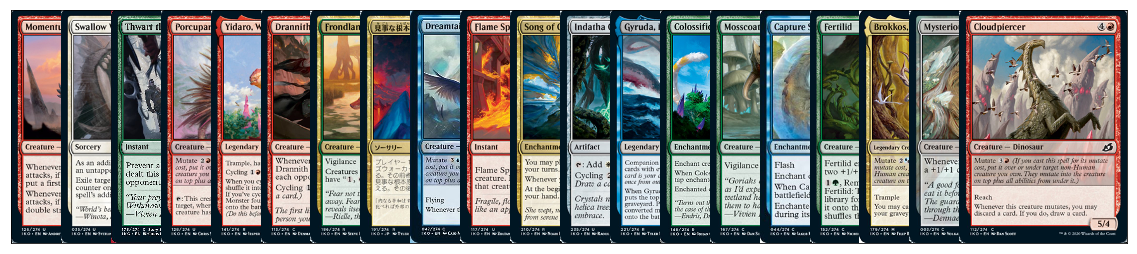

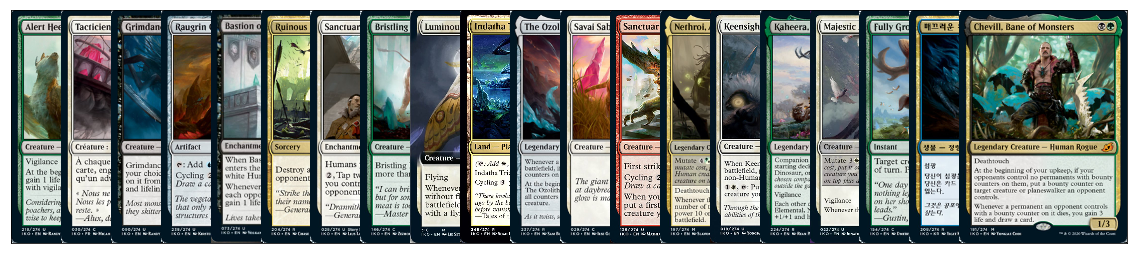

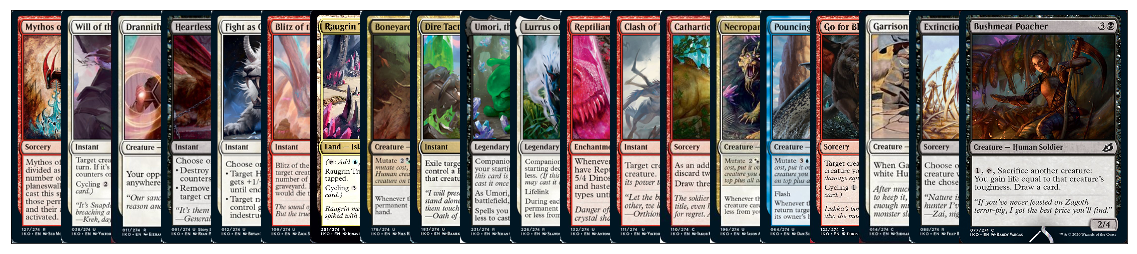

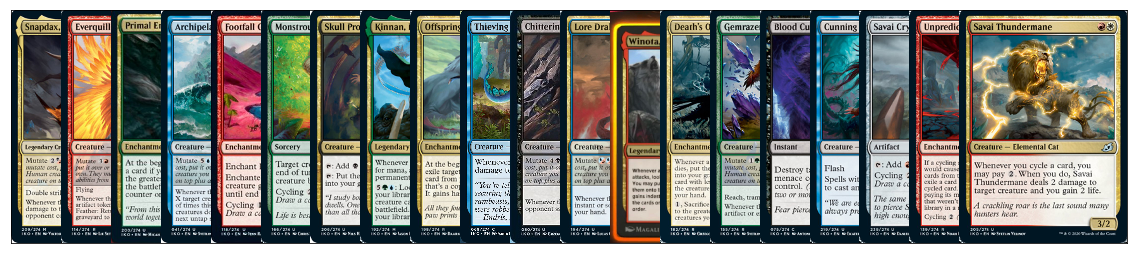

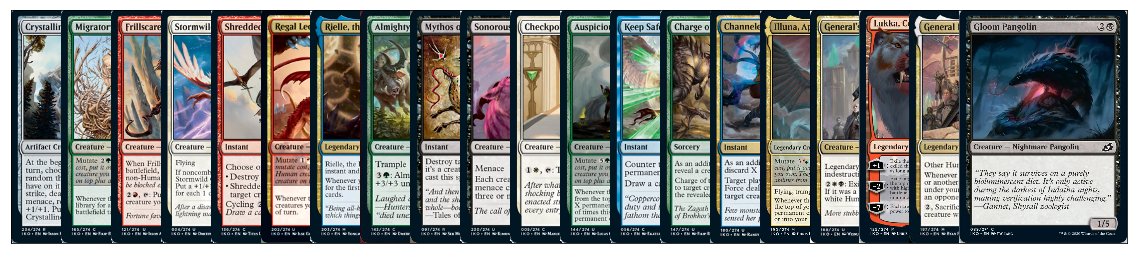

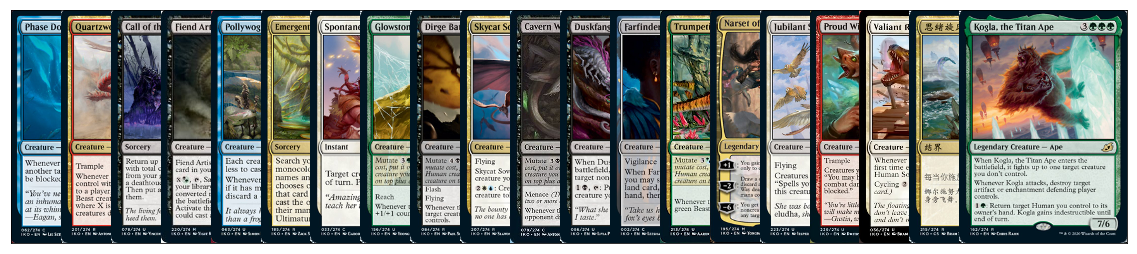

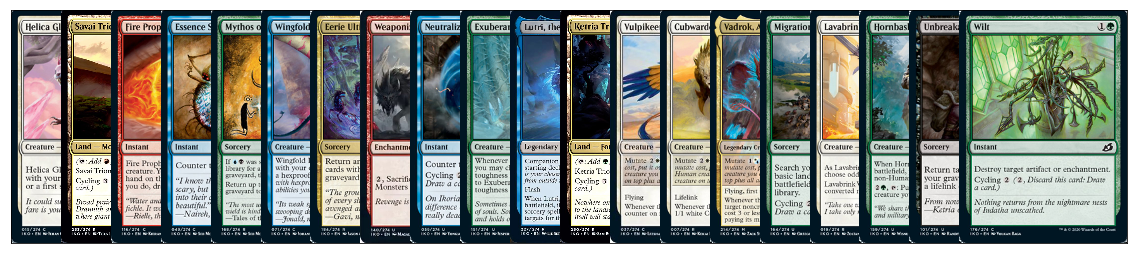

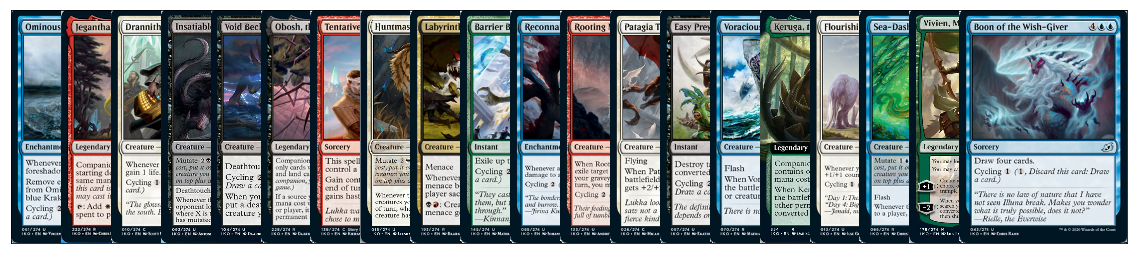

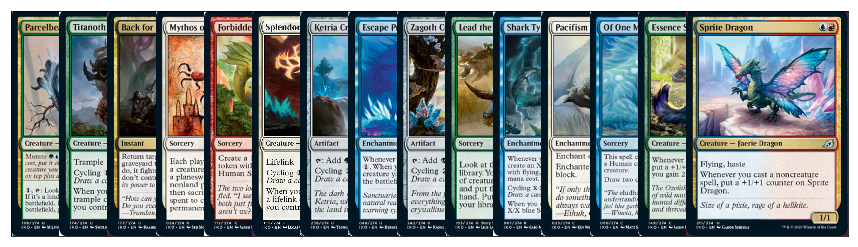

In [6]:
def stack(cards):
    for i in range(len(cards) - 1):
        cards[i] = cards[i][:, : 200, :]
    return numpy.hstack( cards )

def show_cards(cards):
    for i in range(0, len(cards), 20):
        subset = cards[i: min(i + 20, len(cards))]
        plot.figure(figsize = (len(subset), 5))
        
        fig = plot.imshow( stack(subset) )
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
        plot.show()
        
show_cards( card_list )

## Shuffling: Combinatorics in Magic

### Card Ordering
First consider shuffling a deck of $d$ cards, each of which are distinct (let us ignore basic lands for a moment), and ask the obvious question: how many ways are there of shuffling the deck? Let us call this number $S_d$. 

In [10]:
DECK_SIZE = 6

# Insert shuffling animation

Surprisingly, we can starting with just the _first_ (top) card of the deck. Imagine choosing one of these arbitrarily, and shuffling the rest of the deck below it (in fact, cards like <a href="https://scryfall.com/card/ema/112/vampiric-tutor" class = hover> Vampiric Tutor <img src="https://img.scryfall.com/cards/small/front/e/7/e7e778ce-3f1e-4626-8f55-bba03970d91a.jpg?1580014409"/></a> do just this). This $(d-1)$-card subset is independant from the chosen first card, and is therefore equivalent to shuffling a deck of $d-1$ cards, which hopefully matches intuition. So the number of ways of shuffling a $d$-card deck such that a chosen card is on top is the same as the number of ways of shuffling a $(d-1)$-card deck.

Let us repeat this process for each of the possible $d$ first cards. In other words, for each card in the deck, set the card aside as "first", and count how many ways we can shuffle the rest of the deck (which conveniently always equals $S_{d-1}$).

In [ ]:
# Insert sub-shuffling animation

None of the complete shuffles overlap between the choices of first card because, by construction, they all have different first cards. Similarly if we show that $S_{d-1}$ counts all possible shuffles, than $S_d$ must as well, since for each possible shuffle in $S_{d-1}$, our maths perpends all possible first cards. This is the hand-waved version of the formal inductive proof. Mathematically, this means we can add up each "copy" of $S_{d-1}$:

$$S_d = S_{d-1} + S_{d-1} + \dots + S_{d-1} $$
$$S_d = d \cdot S_{d-1} $$

This further gives us a fancy recursion, since $S_{d-1} = (d-1)S_{d-2}$, $S_{d-2} = (d-2)S_{d-3}$, and so on.

So how do we (1) get a number out of this, and (2) prove the inductive correctness of $S_d$? For both, we look to the base case, $S_1 = 1$. Since one card can be shuffled one way, this is obviously correct. Furthermore, any $S_d$ can now be written as:

$$S_d = d \cdot (d - 1) \cdot (d - 2) \cdot \dots \cdot 1 = d!$$

This gives us the same count for all $d$ that the animations above did.

In [22]:
# GAHH

### Shuffling Repeated Cards

However, as mentioned, despite treating each card as unique, we don't particularly care about the indivdual ordering of any particular repeat card. To highlight this, suppose I wrote a number on each card, $1, \cdots, d$. Take two basic mountains, for example, labelled #3 and #17. These are semantically identical in the game of _Magic_. Yet, two shuffles that are otherwise the same, but have Mountains #3 and #17 swapped, are both individually counted.

To undo this, consider a numbered deck of _Magic_ cards, and shuffle the deck. Now, idetify the set of all other shuffles that I can create by taking our starting ordering and _only_ rearranging repeat cards (like basic mountains). Notably, every shuffle in this set is semantically identical.

In [ ]:
# Insert rearrange animation

It would be intuitive to do this for each semantically unique shuffle, and count those, instead. However, notice that all the sets of "equivalent" orderings are the same size: the number of ways of rearranging the repeated cards. For simplicity, suppose the repeats are limited to the $m$ basic mountains (evey other card is unique). This means each set of equivalent shuffles is size $S_m = m!$, since we are effectively asking how many ways can we "shuffle" these lands around, before putting them back in their designated spots. In fact, the animation above relies on this observation in the code.

Since each set of equivalent orderings is size $m!$, and we instead want to count each set once, we can simply multiply the entire number of shuffles by $\frac{1}{m!}$ to "undo" the extra-counting from repeated mountains.

$$S_{n, m} = \frac{n!}{m!}$$

We can also repeat the process to undo the extra-counting from repeated plains, for example, or any other cards we do not want to count as unique:

$$S_{n, m, p} = \frac{n!}{m!p!}$$

In [ ]:
# GAH 2

## Commune with Nature: the Hypergeometric Distribution

### Combinations of Cards

We have so far been working with _permutations_ in our shuffling: what different ways one can rearrange a set of objects, in this case, cards. In the case of draw and reveal spells, we generally care abou _combinations_ instead: what different sets of cards can we pull in the top five, for example. Thankfully, the maths for counting permutations can easily be used to count combinations, instead, which will lead us to probabilities later.

Let's take another look at <a href="https://scryfall.com/card/10e/256/commune-with-nature" class = "hover">Commune With Nature<img src="https://img.scryfall.com/cards/small/front/b/7/b760d616-b73a-4c7f-8a38-5606a9a321e3.jpg?1562554024"/> </a>: when resolving this spell, the player reveals the top five cards of their library, and may put a creature from among them into their hand. Since this card only cares about creatures, lets label each card of our $d$-card deck as either "creature" (of which there will be $c$) or "non-creature" (of which there will be $n$).

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()